<a href="https://colab.research.google.com/github/fmigone/Avako_Counting/blob/master/AI_Cashew_Stat_Innov.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#. Train a Custom Model on DarkNet

#### 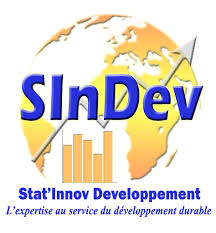

### Cashew Deep Learning Model

In [ ]:
function ClickConnect(){
console.log("Working"); 
document.querySelector("colab-toolbar-button").click() 
}setInterval(ClickConnect,60000)

#### Ouvrir le google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Libraries

In [ ]:
import os
import keras
import imgaug as ia
ia.seed(1)
%matplotlib inline
#!pip install object-detection

In [ ]:
# imageio library will be used for image input/output
import imageio
import pandas as pd
import numpy as np
import re
import os
import glob
# this library is needed to read XML files for converting it into CSV
import xml.etree.ElementTree as ET
import shutil

In [ ]:
repo_url = 'https://github.com/Abubakr05/Cashew_images'

In [ ]:
import os
%cd /content
repo_dir_path = os.path.abspath(os.path.join('.', os.path.basename(repo_url)))
!git clone {repo_url}
%cd {repo_dir_path}
!git pull

/content
Cloning into 'Cashew_images'...
remote: Enumerating objects: 26, done.
remote: Counting objects: 100% (26/26), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 8112 (delta 12), reused 0 (delta 0), pack-reused 8086
Receiving objects: 100% (8112/8112), 2.04 GiB | 39.05 MiB/s, done.
Resolving deltas: 100% (4313/4313), done.
Checking out files: 100% (3802/3802), done.
/content/Cashew_images
Already up to date.


#### Reorgarnisation de l'espace de travail

In [ ]:
%cd /content/Cashew_images/data
!mkdir -p  "images"
!mkdir -p  "annotations"
!pwd

/content/Cashew_images/data
/content/Cashew_images/data


In [ ]:
%cd /content/Cashew_images/data/images/
!mkdir -p  "train"
!mkdir -p  "test"

/content/Cashew_images/data/images


In [ ]:
#combiner les différents dossiers train provenant du repos github en un seul dossier train
import shutil
import os

In [ ]:
#deplacement des images du train
#dossier=["train1","train2","train3","train4","train5","train6"]
dossier=["train1","train2","train3","train4"]
for item in dossier:
	source = "/content/Cashew_images/data/"+item
	destination = "/content/Cashew_images/data/images/train/"

	files = os.listdir(source)

	for file in files:
		new_path = shutil.move(f"{source}/{file}", destination)
		#print(new_path)

In [ ]:
#deplacement des images du test
dossier=["test"]
for item in dossier:
	source = "/content/Cashew_images/data/test"
	destination = "/content/Cashew_images/data/images/test/"

	files = os.listdir(source)

	for file in files:
		new_path = shutil.move(f"{source}/{file}", destination)
		#print(new_path)

#### Data Augmentation

In [ ]:
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage
from imgaug import augmenters as iaa 

In [ ]:
#fonction pour convertir les fichiers XML en un seul fichier CSV
def xml_to_csv(path):
    xml_list = []
    for xml_file in glob.glob(path + '/*.xml'):
        tree = ET.parse(xml_file)
        root = tree.getroot()
        for member in root.findall('object'):
            value = (root.find('filename').text,
                     float(root.find('size')[0].text),
                     float(root.find('size')[1].text),
                     member[0].text,
                     float(member[4][0].text),
                     float(member[4][1].text),
                     float(member[4][2].text),
                     float(member[4][3].text)
                     )
            xml_list.append(value)
    column_name = ['filename', 'width', 'height', 'class', 'xmin', 'ymin', 'xmax', 'ymax']
    xml_df = pd.DataFrame(xml_list, columns=column_name)
    return xml_df

In [ ]:
#conversion des annotation xml en csv - creation d'un fichier csv contenant les annotations
#train 
labels_df_finale_last_train = xml_to_csv('/content/Cashew_images/data/images/train/')
labels_df_finale_last_train.to_csv(('labels_train_finales.csv'), index=None)
#test
labels_df_finale_last_test = xml_to_csv('/content/Cashew_images/data/images/test/')
labels_df_finale_last_train.to_csv(('labels_test_finales.csv'), index=None)

In [ ]:
#fonctions utiles pour la data augmentation à l'aide d'Image Aug
def bbs_obj_to_df(bbs_object):
#     convert BoundingBoxesOnImage object into array
    bbs_array = bbs_object.to_xyxy_array()
#     convert array into a DataFrame ['xmin', 'ymin', 'xmax', 'ymax'] columns
    df_bbs = pd.DataFrame(bbs_array, columns=['xmin', 'ymin', 'xmax', 'ymax'])
    return df_bbs

def resize_imgaug(df, images_path, aug_images_path, image_prefix):
    # create data frame which we're going to populate with augmented image info
    aug_bbs_xy = pd.DataFrame(columns=
                              ['filename','width','height','class', 'xmin', 'ymin', 'xmax', 'ymax']
                             )
    grouped = df.groupby('filename')    

    for filename in df['filename'].unique():
    #   Get separate data frame grouped by file name
        group_df = grouped.get_group(filename)
        group_df = group_df.reset_index()
        group_df = group_df.drop(['index'], axis=1)

    #   If image height is greater than or equal to image width 
    #   AND greater than 600px perform resizing augmentation shrinking image height to 600px.
        if group_df['height'].unique()[0] >= group_df['width'].unique()[0] and group_df['height'].unique()[0] > 600:
        #   read the image
            image = imageio.imread(images_path+filename)
        #   get bounding boxes coordinates and write into array        
            bb_array = group_df.drop(['filename', 'width', 'height', 'class'], axis=1).values
        #   pass the array of bounding boxes coordinates to the imgaug library
            bbs = BoundingBoxesOnImage.from_xyxy_array(bb_array, shape=image.shape)
        #   apply augmentation on image and on the bounding boxes
            image_aug, bbs_aug = height_resize(image=image, bounding_boxes=bbs)
        #   write augmented image to a file
            imageio.imwrite(aug_images_path+image_prefix+filename, image_aug)  
        #   create a data frame with augmented values of image width and height
            info_df = group_df.drop(['xmin', 'ymin', 'xmax', 'ymax'], axis=1)        
            for index, _ in info_df.iterrows():
                info_df.at[index, 'width'] = image_aug.shape[1]
                info_df.at[index, 'height'] = image_aug.shape[0]
        #   rename filenames by adding the predifined prefix
            info_df['filename'] = info_df['filename'].apply(lambda x: image_prefix+x)
        #   create a data frame with augmented bounding boxes coordinates using the function we created earlier
            bbs_df = bbs_obj_to_df(bbs_aug)
        #   concat all new augmented info into new data frame
            aug_df = pd.concat([info_df, bbs_df], axis=1)
        #   append rows to aug_bbs_xy data frame
            aug_bbs_xy = pd.concat([aug_bbs_xy, aug_df])

    #   if image width is greater than image height 
    #   AND greater than 600px perform resizing augmentation shrinking image width to 600px
        elif group_df['width'].unique()[0] > group_df['height'].unique()[0] and group_df['width'].unique()[0] > 600:
        #   read the image
            image = imageio.imread(images_path+filename)
        #   get bounding boxes coordinates and write into array        
            bb_array = group_df.drop(['filename', 'width', 'height', 'class'], axis=1).values
        #   pass the array of bounding boxes coordinates to the imgaug library
            bbs = BoundingBoxesOnImage.from_xyxy_array(bb_array, shape=image.shape)
        #   apply augmentation on image and on the bounding boxes
            image_aug, bbs_aug = width_resize(image=image, bounding_boxes=bbs)
        #   write augmented image to a file
            imageio.imwrite(aug_images_path+image_prefix+filename, image_aug)  
        #   create a data frame with augmented values of image width and height
            info_df = group_df.drop(['xmin', 'ymin', 'xmax', 'ymax'], axis=1)        
            for index, _ in info_df.iterrows():
                info_df.at[index, 'width'] = image_aug.shape[1]
                info_df.at[index, 'height'] = image_aug.shape[0]
        #   rename filenames by adding the predifined prefix
            info_df['filename'] = info_df['filename'].apply(lambda x: image_prefix+x)
        #   create a data frame with augmented bounding boxes coordinates using the function we created earlier
            bbs_df = bbs_obj_to_df(bbs_aug)
        #   concat all new augmented info into new data frame
            aug_df = pd.concat([info_df, bbs_df], axis=1)
        #   append rows to aug_bbs_xy data frame
            aug_bbs_xy = pd.concat([aug_bbs_xy, aug_df])

    #     append image info without any changes if it's height and width are both less than 600px 
        else:
            aug_bbs_xy = pd.concat([aug_bbs_xy, group_df])
    # return dataframe with updated images and bounding boxes annotations 
    aug_bbs_xy = aug_bbs_xy.reset_index()
    aug_bbs_xy = aug_bbs_xy.drop(['index'], axis=1)
    return aug_bbs_xy

In [ ]:
#fonctions utiles pour la data augmentation à l'aide d'Image Aug
def image_aug(df, images_path, aug_images_path, image_prefix, augmentor):
    # create data frame which we're going to populate with augmented image info
    aug_bbs_xy = pd.DataFrame(columns=
                              ['filename','width','height','class', 'xmin', 'ymin', 'xmax', 'ymax']
                             )
    grouped = df.groupby('filename')
    
    for filename in df['filename'].unique():
    #   get separate data frame grouped by file name
        group_df = grouped.get_group(filename)
        group_df = group_df.reset_index()
        group_df = group_df.drop(['index'], axis=1)   
    #   read the image
        image = imageio.imread(images_path+filename)
    #   get bounding boxes coordinates and write into array        
        bb_array = group_df.drop(['filename', 'width', 'height', 'class'], axis=1).values
    #   pass the array of bounding boxes coordinates to the imgaug library
        bbs = BoundingBoxesOnImage.from_xyxy_array(bb_array, shape=image.shape)
    #   apply augmentation on image and on the bounding boxes
        image_aug, bbs_aug = augmentor(image=image, bounding_boxes=bbs)
    #   disregard bounding boxes which have fallen out of image pane    
        bbs_aug = bbs_aug.remove_out_of_image()
    #   clip bounding boxes which are partially outside of image pane
        bbs_aug = bbs_aug.clip_out_of_image()
        
    #   don't perform any actions with the image if there are no bounding boxes left in it    
        if re.findall('Image...', str(bbs_aug)) == ['Image([]']:
            pass
        
    #   otherwise continue
        else:
        #   write augmented image to a file
            try:
                imageio.imwrite(aug_images_path+image_prefix+filename, image_aug)
            except:
                pass
        #   create a data frame with augmented values of image width and height
            info_df = group_df.drop(['xmin', 'ymin', 'xmax', 'ymax'], axis=1)    
            for index, _ in info_df.iterrows():
                info_df.at[index, 'width'] = image_aug.shape[1]
                info_df.at[index, 'height'] = image_aug.shape[0]
        #   rename filenames by adding the predifined prefix
            info_df['filename'] = info_df['filename'].apply(lambda x: image_prefix+x)
        #   create a data frame with augmented bounding boxes coordinates using the function we created earlier
            bbs_df = bbs_obj_to_df(bbs_aug)
        #   concat all new augmented info into new data frame
            aug_df = pd.concat([info_df, bbs_df], axis=1)
        #   append rows to aug_bbs_xy data frame
            aug_bbs_xy = pd.concat([aug_bbs_xy, aug_df])            
    
    # return dataframe with updated images and bounding boxes annotations 
    aug_bbs_xy = aug_bbs_xy.reset_index()
    aug_bbs_xy = aug_bbs_xy.drop(['index'], axis=1)
    return aug_bbs_xy

In [ ]:
#Sequence d'augmentation - elle définit quelle opération sera réalisée dans le cadre de l'augmentation
aug = iaa.Sequential([
    iaa.Affine(rotate=(-10,10)),
    iaa.AdditiveGaussianNoise(scale=(0.05*255, 0.05*255)),
    iaa.Multiply(1.25)
])

In [ ]:
#definition du dossier des données d'images initiales
image_init_train = '/content/Cashew_images/data/images/train/'

In [ ]:
## Realisation de l'augmentation pour les données train
augmented_images_df_train = image_aug(labels_df_finale_last_train, image_init_train, image_init_train, 'aug1_', aug)

In [ ]:
#definition du dossier des données d'images initiales
image_init_test = '/content/Cashew_images/data/images/test/'

In [ ]:
## Realisation de l'augmentation pour les données train
augmented_images_df_test = image_aug(labels_df_finale_last_test, image_init_test, image_init_test, 'aug1_', aug)

In [ ]:
#on crée une fonction true_name pour récupérer le nom des images sans l'extension ".jpg" dans le but de faire les fichiers d'annotations au format yolo plus tard
def true_name(f):
  return f.split('.jpg')[0]

In [ ]:
data_csv_train = pd.concat([augmented_images_df_train,labels_df_finale_last_train])
data_csv_test = pd.concat([augmented_images_df_test,labels_df_finale_last_test])

In [ ]:
data_csv_train['name'] = data_csv_train['filename'].apply (lambda row: true_name(row))
data_csv_test['name'] = data_csv_test['filename'].apply (lambda row: true_name(row))

In [ ]:
data_csv_train.dropna(subset = ["xmin"], inplace=True)
data_csv_test.dropna(subset = ["xmin"], inplace=True)

In [ ]:
####  Conversion des annotations CSV en Yolo Format

In [ ]:
#recupération de la liste des éléments des classes
%cd '/content/Cashew_images/data'
import csv
from tqdm import tqdm
import pandas as pd
classes_names = []
data = pd.read_excel('/content/Cashew_images/class.xlsx',index_col=None)
classes_names = data['label'].tolist()

/content/Cashew_images/data


In [ ]:
#Classe pour la conversion des annotations csv en annotations yolo
class YOLOWriter(object):

  def __init__(self,name,data,class_list):
    self.name = name
    self.data_csv = data
    self.bb_data_frame = None
    self.boxlist = []
    self.classList = class_list

  def create_bb(self):
      group = self.data_csv.groupby('name')
      bb_data_frame = group.get_group(self.name)
      self.bb_data_frame = bb_data_frame
      return bb_data_frame 

  def addBndBox(self, filename,xmin, ymin, xmax, ymax,name,width,height):
    bndbox = {'xmin': xmin, 'ymin': ymin, 'xmax': xmax, 'ymax': ymax,'width':width,'height':height}
    bndbox['name'] = name
    bndbox['filename'] = filename
    self.boxlist.append(bndbox)

  def bb_from_df_to_list(self):
    for index,row in self.bb_data_frame.iterrows():
      self.addBndBox(row['filename'],row['xmin'],row['ymin'],row['xmax'],row['ymax'],row['class'],row['width'],row['height'])

  def Yolo_calculus(self,box,classList=[]):
    xmin = box['xmin']
    xmax = box['xmax']
    ymin = box['ymin']
    ymax = box['ymax']
    im1 = box['width']
    im2 = box['height']
    if (im1 == 0 or im2 == 0):
      print(box['name']) 
      print(box['filename'])

    xcen = float((xmin + xmax)) / 2 / im1
    ycen = float((ymin + ymax)) / 2 / im2

    w = float((xmax - xmin)) / im1
    h = float((ymax - ymin)) / im2

    boxName = box['name']
    if boxName not in classList:
      self.classList.append(boxName)
    classIndex = classList.index(boxName)

    return classIndex, xcen, ycen, w, h

  def save_to_yolo(self):
    out_file = open(
        self.name + ".txt",'w',encoding = 'utf-8'
    )
    for box in self.boxlist:
      classIndex, xcen, ycen, w, h = self.Yolo_calculus(box,self.classList)
      out_file.write("%d %.6f %.6f %.6f %.6f\n" % (classIndex, xcen, ycen, w, h))
    out_file.close()

  def work(self):
    self.create_bb()
    self.bb_from_df_to_list()
    self.save_to_yolo()

In [ ]:
#train
%cd '/content/Cashew_images/data/images/train'
for index,ligne in data_csv_train.iterrows():
  yolo =  YOLOWriter(ligne['name'],data_csv_train,classes_names)
  yolo.work()

/content/Cashew_images/data/images/train


In [ ]:
#test
%cd '/content/Cashew_images/data/images/test'
for index,ligne in data_csv_test.iterrows():
  yolo =  YOLOWriter(ligne['name'],data_csv_test,classes_names)
  yolo.work()

In [ ]:
#creation du fichier "train" contenant les liens vers les images d'entrainement
%cd '/content/Cashew_images/data/images/train'
list_file = open('train.txt', 'w')
for name in data_csv_train['name'].unique():
  list_file.write('/content/Cashew_images/data/images/train/%s.jpg\n'%name)
list_file.close()

In [ ]:
#creation du fichier "test" contenant les liens vers les images d'entrainement
%cd '/content/Cashew_images/data/images/test'
list_file = open('test.txt', 'w')
for name in data_csv_test['name'].unique():
  list_file.write('/content/Cashew_images/data/images/test/%s.jpg\n'%name)
list_file.close()

## Configuring CUDA on Colab for YOLOv4

In [ ]:
# CUDA: Let's check that Nvidia CUDA drivers are already pre-installed and which version is it. This can be helpful for debugging.
!/usr/local/cuda/bin/nvcc --version

**IMPORTANT!** If you're not training on a Tesla P100 GPU, we will need to tweak our Darknet configuration later based on what type of GPU we have. Let's set that now while we're inspecting the GPU.

In [ ]:
#take a look at the kind of GPU we have
!nvidia-smi

In [ ]:
# Change the number depending on what GPU is listed above, under NVIDIA-SMI > Name.
# Tesla K80: 30
# Tesla P100: 60
# Tesla T4: 75
%env compute_capability=60

## Installing Darknet for YOLOv4 on Colab

In [ ]:
%cd /content/
%rm -rf darknet

In [ ]:
!git clone https://github.com/AlexeyAB/darknet

**IMPORTANT! If you're not using a Tesla P100 GPU**, then uncomment the sed command and replace the arch and code with that matching your GPU. A list can be found [here](http://arnon.dk/matching-sm-architectures-arch-and-gencode-for-various-nvidia-cards/). You can check with the command nvidia-smi (should be run above).

In [ ]:
#install environment from the Makefile
%cd darknet/
# compute_30, sm_30 for Tesla K80
# compute_75, sm_75 for Tesla T4
# !sed -i 's/ARCH= -gencode arch=compute_60,code=sm_60/ARCH= -gencode arch=compute_30,code=sm_30/g' Makefile

#install environment from the Makefile
#note if you are on Colab Pro this works on a P100 GPU
#if you are on Colab free, you may need to change the Makefile for the K80 GPU
#this goes for any GPU, you need to change the Makefile to inform darknet which GPU you are running on.
!sed -i 's/OPENCV=0/OPENCV=1/g' Makefile
!sed -i 's/GPU=0/GPU=1/g' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/g' Makefile
!sed -i "s/ARCH= -gencode arch=compute_60,code=sm_60/ARCH= -gencode arch=compute_${compute_capability},code=sm_${compute_capability}/g" Makefile
!make

[Errno 2] No such file or directory: 'darknet/'
/content/darknet/data
sed: can't read Makefile: No such file or directory
sed: can't read Makefile: No such file or directory
sed: can't read Makefile: No such file or directory
sed: can't read Makefile: No such file or directory
make: *** No targets specified and no makefile found.  Stop.


In [ ]:
#download the newly released yolov4-tiny weights
%cd /content/darknet
!wget https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v4_pre/yolov4-tiny.weights
!wget https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v4_pre/yolov4-tiny.conv.29

In [ ]:
#creation des fichiers nécessaires 
#obj.names
# Write the strings in the list to text file
%cd '/content/darknet/data'
with open('obj.names', 'w') as writefile:
    for line in classes_names:
        print(line)
        writefile.write(line+'\n')
%cat '/content/darknet/data/obj.names'

In [ ]:
len(classes_names)
%cd '/content/darknet/data'
with open('obj.data', 'w') as writefile:
  writefile.write('classes = 12'+'\n')
  writefile.write('train  = data/train.txt'+'\n')
  writefile.write('valid  = data/test.txt'+'\n')
  writefile.write('names  = data/obj.names'+'\n')
  writefile.write('backup = backup/'+'\n')

In [ ]:
shutil.copy('/content/Cashew_images/data/images/train/train.txt','/content/darknet/data/')
shutil.copy('/content/Cashew_images/data/images/test/test.txt','/content/darknet/data/')

'/content/darknet/data/test.txt'

## Configure from Custom Dataset

## Write Custom Training Config for YOLOv4

In [ ]:
#we build config dynamically based on number of classes
#we build iteratively from base config files. This is the same file shape as cfg/yolo-obj.cfg
def file_len(fname):
  with open(fname) as f:
    for i, l in enumerate(f):
      pass
  return i + 1

num_classes = file_len('/content/darknet/data/obj.names')
max_batches = num_classes*2000
steps1 = .8 * max_batches
steps2 = .9 * max_batches
steps_str = str(steps1)+','+str(steps2)
num_filters = (num_classes + 5) * 3


print("writing config for a custom YOLOv4 detector detecting number of classes: " + str(num_classes))

#Instructions from the darknet repo
#change line max_batches to (classes*2000 but not less than number of training images, and not less than 6000), f.e. max_batches=6000 if you train for 3 classes
#change line steps to 80% and 90% of max_batches, f.e. steps=4800,5400
if os.path.exists('./cfg/custom-yolov4-tiny-detector.cfg'): os.remove('./cfg/custom-yolov4-tiny-detector.cfg')


#customize iPython writefile so we can write variables
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

  



writing config for a custom YOLOv4 detector detecting number of classes: 12


In [ ]:
%%writetemplate /content/darknet/cfg/yolov4-tiny-custom.cfg
[net]
# Testing
#batch=1
#subdivisions=1
# Training
batch=64
subdivisions=16
width=416
height=416
channels=3
momentum=0.9
decay=0.0005
angle=0
saturation = 1.5
exposure = 1.5
hue=.1

learning_rate=0.00261
burn_in=1000
max_batches = {max_batches}
policy=steps
steps={steps_str}
scales=.1,.1

[convolutional]
batch_normalize=1
filters=32
size=3
stride=2
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=64
size=3
stride=2
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=64
size=3
stride=1
pad=1
activation=leaky

[route]
layers=-1
groups=2
group_id=1

[convolutional]
batch_normalize=1
filters=32
size=3
stride=1
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=32
size=3
stride=1
pad=1
activation=leaky

[route]
layers = -1,-2

[convolutional]
batch_normalize=1
filters=64
size=1
stride=1
pad=1
activation=leaky

[route]
layers = -6,-1

[maxpool]
size=2
stride=2

[convolutional]
batch_normalize=1
filters=128
size=3
stride=1
pad=1
activation=leaky

[route]
layers=-1
groups=2
group_id=1

[convolutional]
batch_normalize=1
filters=64
size=3
stride=1
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=64
size=3
stride=1
pad=1
activation=leaky

[route]
layers = -1,-2

[convolutional]
batch_normalize=1
filters=128
size=1
stride=1
pad=1
activation=leaky

[route]
layers = -6,-1

[maxpool]
size=2
stride=2

[convolutional]
batch_normalize=1
filters=256
size=3
stride=1
pad=1
activation=leaky

[route]
layers=-1
groups=2
group_id=1

[convolutional]
batch_normalize=1
filters=128
size=3
stride=1
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=128
size=3
stride=1
pad=1
activation=leaky

[route]
layers = -1,-2

[convolutional]
batch_normalize=1
filters=256
size=1
stride=1
pad=1
activation=leaky

[route]
layers = -6,-1

[maxpool]
size=2
stride=2

[convolutional]
batch_normalize=1
filters=512
size=3
stride=1
pad=1
activation=leaky

##################################

[convolutional]
batch_normalize=1
filters=256
size=1
stride=1
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=512
size=3
stride=1
pad=1
activation=leaky

[convolutional]
size=1
stride=1
pad=1
filters={num_filters}
activation=linear



[yolo]
mask = 3,4,5
anchors = 10,14,  23,27,  37,58,  81,82,  135,169,  344,319
classes={num_classes}
num=6
jitter=.3
scale_x_y = 1.05
cls_normalizer=1.0
iou_normalizer=0.07
iou_loss=ciou
ignore_thresh = .7
truth_thresh = 1
random=0
nms_kind=greedynms
beta_nms=0.6

[route]
layers = -4

[convolutional]
batch_normalize=1
filters=128
size=1
stride=1
pad=1
activation=leaky

[upsample]
stride=2

[route]
layers = -1, 23

[convolutional]
batch_normalize=1
filters=256
size=3
stride=1
pad=1
activation=leaky

[convolutional]
size=1
stride=1
pad=1
filters={num_filters}
activation=linear

[yolo]
mask = 1,2,3
anchors = 10,14,  23,27,  37,58,  81,82,  135,169,  344,319
classes={num_classes}
num=6
jitter=.3
scale_x_y = 1.05
cls_normalizer=1.0
iou_normalizer=0.07
iou_loss=ciou
ignore_thresh = .7
truth_thresh = 1
random=0
nms_kind=greedynms
beta_nms=0.6

In [ ]:
#here is the file that was just written. 
#you may consider adjusting certain things

#like the number of subdivisions 64 runs faster but Colab GPU may not be big enough
#if Colab GPU memory is too small, you will need to adjust subdivisions to 16
%cat /content/darknet/cfg/yolov4-tiny-custom.cfg

[net]
# Testing
#batch=1
#subdivisions=1
# Training
batch=64
subdivisions=16
width=416
height=416
channels=3
momentum=0.9
decay=0.0005
angle=0
saturation = 1.5
exposure = 1.5
hue=.1

learning_rate=0.00261
burn_in=1000
max_batches = 24000
policy=steps
steps=19200.0,21600.0
scales=.1,.1

[convolutional]
batch_normalize=1
filters=32
size=3
stride=2
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=64
size=3
stride=2
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=64
size=3
stride=1
pad=1
activation=leaky

[route]
layers=-1
groups=2
group_id=1

[convolutional]
batch_normalize=1
filters=32
size=3
stride=1
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=32
size=3
stride=1
pad=1
activation=leaky

[route]
layers = -1,-2

[convolutional]
batch_normalize=1
filters=64
size=1
stride=1
pad=1
activation=leaky

[route]
layers = -6,-1

[maxpool]
size=2
stride=2

[convolutional]
batch_normalize=1
filters=128
size=3
stride=1
pad=1
activation=leaky

[ro

## Train Custom YOLOv4 Detector

In [ ]:
%cd /content/darknet/
!./darknet detector train data/obj.data cfg/yolov4-tiny-custom.cfg yolov4-tiny.conv.29 -dont_show -map
#If you get CUDA out of memory adjust subdivisions above!
#adjust max batches down for shorter training above

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
v3 (iou loss, Normalizer: (iou: 0.07, cls: 1.00) Region 30 Avg (IOU: 0.555185, GIOU: 0.548502), Class: 0.549436, Obj: 0.070172, No Obj: 0.002271, .5R: 0.600000, .75R: 0.200000, count: 10, class_loss = 3.084353, iou_loss = 0.565099, total_loss = 3.649452 
v3 (iou loss, Normalizer: (iou: 0.07, cls: 1.00) Region 37 Avg (IOU: 0.545850, GIOU: 0.512597), Class: 0.615791, Obj: 0.018244, No Obj: 0.000696, .5R: 0.727273, .75R: 0.090909, count: 11, class_loss = 3.446739, iou_loss = 1.237649, total_loss = 4.684388 
 total_bbox = 173985, rewritten_bbox = 0.098284 % 
v3 (iou loss, Normalizer: (iou: 0.07, cls: 1.00) Region 30 Avg (IOU: 0.625704, GIOU: 0.620588), Class: 0.744990, Obj: 0.137830, No Obj: 0.002181, .5R: 1.000000, .75R: 0.333333, count: 3, class_loss = 0.790578, iou_loss = 0.424677, total_loss = 1.215255 
v3 (iou loss, Normalizer: (iou: 0.07, cls: 1.00) Region 37 Avg (IOU: 0.585558, GIOU: 0.554113), Class: 0.39

## Infer Custom Objects with Saved YOLOv4 Weights

In [ ]:
#define utility function
def imShow(path):
  import cv2
  import matplotlib.pyplot as plt
  %matplotlib inline

  image = cv2.imread(path)
  height, width = image.shape[:2]
  resized_image = cv2.resize(image,(3*width, 3*height), interpolation = cv2.INTER_CUBIC)

  fig = plt.gcf()
  fig.set_size_inches(18, 10)
  plt.axis("off")
  #plt.rcParams['figure.figsize'] = [10, 5]
  plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
  plt.show()

In [ ]:
#check if weigths have saved yet
#backup houses the last weights for our detector
#(file yolo-obj_last.weights will be saved to the build\darknet\x64\backup\ for each 100 iterations)
#(file yolo-obj_xxxx.weights will be saved to the build\darknet\x64\backup\ for each 1000 iterations)
#After training is complete - get result yolo-obj_final.weights from path build\darknet\x64\bac
!ls backup
#if it is empty you haven't trained for long enough yet, you need to train for at least 100 iterations

In [ ]:
# Darknet Weights
!cp /content/darknet/backup/yolov4-tiny-custom_final.weights "/content/drive/My Drive"

In [ ]:
#coco.names is hardcoded somewhere in the detector
%cp data/obj.names data/coco.names

In [ ]:

#/test has images that we can test our detector on
test_images = [f for f in os.listdir('test') if f.endswith('.jpg')]
import random
img_path = "test/" + random.choice(test_images);

#test out our detector!
!./darknet detect cfg/custom-yolov4-tiny-detector.cfg backup/custom-yolov4-tiny-detector_best.weights {img_path} -dont-show
imShow('predictions.jpg')

#. Convert the weights to TensorFlow's .pb representation

## Install and Configure

In [ ]:
%cd /content
!git clone https://github.com/hunglc007/tensorflow-yolov4-tflite.git
%cd /content/tensorflow-yolov4-tflite

In [ ]:
!cp /content/darknet/data/obj.names /content/tensorflow-yolov4-tflite/data/classes/
!ls /content/tensorflow-yolov4-tflite/data/classes/

In [ ]:
!sed -i "s/coco.names/obj.names/g" /content/tensorflow-yolov4-tflite/core/config.py

## Convert

In [ ]:
%cd /content/tensorflow-yolov4-tflite
# Regular TensorFlow SavedModel
!python save_model.py \
  --weights /content/darknet/backup/yolov4-tiny-custom_final.weights \
  --output ./checkpoints/yolov4-tiny-416 \
  --input_size 416 \
  --model yolov4 \
  --tiny \

# SavedModel to convert to TFLite
!python save_model.py \
  --weights /content/darknet/backup/yolov4-tiny-custom_final.weights \
  --output ./checkpoints/yolov4-tiny-pretflite-416 \
  --input_size 416 \
  --model yolov4 \
  --tiny \
  --framework tflite

#. Convert the TensorFlow weights to TensorFlow Lite

In [ ]:
%cd /content/tensorflow-yolov4-tflite
!python convert_tflite.py --weights ./checkpoints/yolov4-tiny-pretflite-416 --output ./checkpoints/yolov4-tiny-416.tflite 

In [ ]:
#conversion en full_int8
%cd /content/tensorflow-yolov4-tflite
!python convert_tflite.py --weights ./checkpoints/yolov4-tiny-pretflite-416 --output ./checkpoints/yolov4-tiny-416.tflite --quantize_mode full_int8 

In [ ]:
#conversion en float16
%cd /content/tensorflow-yolov4-tflite
!python convert_tflite.py --weights ./checkpoints/yolov4-tiny-pretflite-416 --output ./checkpoints/yolov4-tiny-416.tflite --quantize_mode float16

In [ ]:
import tensorflow as tf
converter = tf.lite.TFLiteConverter.from_saved_model('./checkpoints/yolov4-tiny-pretflite-416 ')
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quant_model = converter.convert()

In [ ]:
!ls /content/darknet/test

In [ ]:
%cd /content/tensorflow-yolov4-tflite/
!ls
from IPython.display import Image
Image('/content/tensorflow-yolov4-tflite/result.png')

# Save your Model

In [ ]:
# Choose what to copy

# TensorFlow SavedModel
!cp -r /content/tensorflow-yolov4-tflite/checkpoints/yolov4-tiny-416/ "/content/drive/My Drive"
# TensorFlow Lite
!cp /content/tensorflow-yolov4-tflite/checkpoints/yolov4-tiny-416.tflite "/content/drive/My Drive"